In [1]:
import torch
torch.manual_seed(0)
from torch.nn import Module

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
dtype = torch.double

from botorch.test_functions.synthetic import SyntheticTestFunction
from torch import Tensor
import torch
from typing import Optional


In [2]:
from fast_soft_sort import pytorch_ops
import functools

In [3]:
DIM = 12
K = 8

In [4]:
from permutation_transforms import RankRoundTransform, PerturbedRankTransform, SoftRankTransform

In [5]:
hard_round_transform = RankRoundTransform(indices=[0, 1, 2], hard=True)
hard_round_transform(torch.rand(1, DIM, dtype=dtype))

tensor([[0.6667, 0.3333, 0.0000, 0.3069, 0.2150, 0.2637, 0.0595, 0.1170, 0.1938,
         0.0961, 0.1510, 0.0589]], dtype=torch.float64)

In [6]:
ranked_indices = range(DIM)
soft_rank_transform = SoftRankTransform(indices=ranked_indices, regularization_strength=0.25, regularization_type="l2")
pert_rank_transform = PerturbedRankTransform(indices=ranked_indices, num_samples=1000, sigma=0.03)
hard_round_transform = RankRoundTransform(indices=ranked_indices, hard=True)
soft_round_transform = RankRoundTransform(indices=ranked_indices, hard=False, tau=1e-3)

label_to_transform_dict = {
    "soft_rank_transform": soft_rank_transform,
#     "pert_rank_transform": pert_rank_transform,
    "gpei": None, 
    "hard_round": hard_round_transform, 
    "soft_round": soft_round_transform, 
}

rand_mat = torch.rand(1, DIM, device=device, dtype=dtype)
for transform in label_to_transform_dict.values():
    if transform:
        print(transform(rand_mat))

tensor([[0.5078, 0.5967, 0.5500, 0.5363, 0.5251, 0.4578, 0.6110, 0.6510, 0.4595,
         0.6149, 0.4259, 0.5639]], dtype=torch.float64)
tensor([[0.2500, 0.6667, 0.5000, 0.4167, 0.3333, 0.0833, 0.7500, 0.9167, 0.1667,
         0.8333, 0.0000, 0.5833]], dtype=torch.float64)
tensor([[0.2500, 0.6667, 0.5000, 0.4167, 0.3333, 0.0839, 0.7500, 0.9167, 0.1661,
         0.8333, 0.0000, 0.5833]], dtype=torch.float64)


In [7]:
from permutation_synthetic_functions import PermutationCorrelation
perm = PermutationCorrelation(dim=DIM, n=1)
# topk = TopK(dim=DIM, k=K)
# hartmann_over_perm = HartmannPermutationConstrained(negate=True)
# jennaton = Jennaton(negate=True)

def weighted_obj(X):
    """Feasibility weighted objective; zero if not feasible."""
    return perm(X)

# torch.max(weighted_obj(torch.rand(16, 6, DIM, device=device)), dim=-1)
# weighted_obj(perm.target_perms[0])
# weighted_obj(topk.target_vals)
weighted_obj(torch.rand(10, DIM, device=device, dtype=dtype))

tensor([ 0.1329,  0.5245, -0.5035, -0.2238,  0.1049,  0.0769,  0.0699, -0.0629,
         0.3147,  0.2937], dtype=torch.float64)

In [8]:
BATCH_SIZE = 1
N_TRIALS = 3
N_BATCH = 25
N_INITIAL_BATCHES = 5

In [9]:
from experiment_utils import generate_test_run, initialize_ranking_model

In [10]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
def plot_results(label_to_results_dict, y_min=0.5, y_max=1.0):

    def ci(y):
        return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)

    import math
    GLOBAL_MAXIMUM = y_max


    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    iters = np.arange(N_BATCH + 1) * BATCH_SIZE

    for label, results in label_to_results_dict.items():
        y = np.asarray(results)
        ax.errorbar(iters, y.mean(axis=0), yerr=ci(y), label=label, linewidth=1.5)

    plt.plot([0, N_BATCH * BATCH_SIZE], [GLOBAL_MAXIMUM] * 2, 'k', label="true best objective", linewidth=2)
    ax.set_ylim(bottom=y_min)
    ax.set(xlabel='number of observations (beyond initial points)', ylabel='best objective value')
    ax.legend(loc="upper left")
    
import json
def save_results(experiment_title):
    # experiment_title = "ranking_main_test_jennaton_one_hot_noise_0_0_fast_opt"
    file = open(f"{experiment_title}_results.json", 'w')
    json.dump(label_to_results_dict, file)

    file.flush()
    file.close()
    
def performance_summary(label_to_results_dict):
    label_to_performance_dict = {
        label: np.asarray(results).mean(axis=0)[-1] for label, results in label_to_results_dict.items()
    }

    label_to_performance_dict


    import pandas as pd
    rows = []
    for label, performance in label_to_performance_dict.items():
        rows.append({"label": label, "performance": performance})

    return pd.DataFrame(rows)

In [11]:
ranked_indices = range(DIM)
soft_rank_transform = SoftRankTransform(indices=ranked_indices, regularization_strength=0.25, regularization_type="l2")
pert_rank_transform = PerturbedRankTransform(indices=ranked_indices, num_samples=1000, sigma=0.03)
hard_round_transform = RankRoundTransform(indices=ranked_indices, hard=True)
soft_round_transform = RankRoundTransform(indices=ranked_indices, hard=False, tau=1e-3)

import itertools

label_to_transform_dict = {
    "soft_rank_transform": soft_rank_transform,
    "pert_rank_transform": pert_rank_transform,
    "gpei": None, 
    "hard_round": hard_round_transform, 
    "soft_round": soft_round_transform, 
}

In [12]:
experiment_results = {}

In [28]:
# Set Noise
NOISE_SE = 0.2
label_to_model_dict = {
    label: functools.partial(
        initialize_ranking_model, model_type="FNGP", noise_se=NOISE_SE, transform=transform
    )
    for label, transform in label_to_transform_dict.items()
}
label_to_results_dict = {}
exceptions = {}

initial_data_list, run_trials = generate_test_run(
    obj_func=weighted_obj,
    dim=DIM,
    batch_size=BATCH_SIZE,
    n_trials=N_TRIALS,
    n_bo_batch=N_BATCH,
    n_sobol_batch=N_INITIAL_BATCHES,
    noise_se=NOISE_SE,
)

import time
start = time.time()
for label, model in label_to_model_dict.items():
    try:
        label_to_results_dict[label] = run_trials(N_TRIALS, model, label, initial_data_list)
    except Exception as e:
        exceptions[label] = e
end = time.time()

name = "noise_{noise_se}"
experiment_results[name] = label_to_results_dict
print(exceptions)
# %debug
print("total time", end-start)


Trial  1 of 32 ....................
Trial  2 of 32 ....................
Trial  3 of 32 ....................
Trial  4 of 32 ....................
Trial  5 of 32 ....................
Trial  6 of 32 ....................
Trial  7 of 32 ....................
Trial  8 of 32 ....................
Trial  9 of 32 ....................
Trial 10 of 32 ....................
Trial 11 of 32 ....................
Trial 12 of 32 ....................
Trial 13 of 32 ....................
Trial 14 of 32 ....................
Trial 15 of 32 ....................
Trial 16 of 32 ....................
Trial 17 of 32 ....................
Trial 18 of 32 ....................
Trial 19 of 32 ....................
Trial 20 of 32 ....................
Trial 21 of 32 ....................
Trial 22 of 32 ....................
Trial 23 of 32 ....................
Trial 24 of 32 ....................
Trial 25 of 32 ....................
Trial 26 of 32 ....................
Trial 27 of 32 ....................
Trial 28 of 32 ............

,label,performance
0,soft_rank_transform,0.890953
1,gpei,0.803322
2,hard_round,0.863418
3,soft_round,0.861014


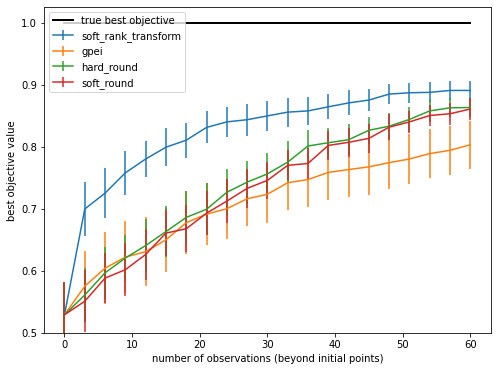

In [29]:
plot_results(experiment_results[name])

performance_summary(experiment_results[name])

In [27]:
max_so_far = -1
trials = 100
samples = 10000
random_train_x = torch.rand(trials*samples, DIM, device=device, dtype=dtype)
random_evaluations = weighted_obj(random_train_x).reshape(trials, samples)
mean_running_max = random_evaluations.cummax(-1).values.mean(dim=0)
mean_running_max[range(0, samples, int(samples/100))]

tensor([-0.0203,  0.7077,  0.7583,  0.7778,  0.7924,  0.8050,  0.8155,  0.8211,
         0.8249,  0.8303,  0.8327,  0.8344,  0.8384,  0.8408,  0.8436,  0.8465,
         0.8483,  0.8507,  0.8522,  0.8540,  0.8552,  0.8566,  0.8576,  0.8587,
         0.8600,  0.8613,  0.8614,  0.8621,  0.8636,  0.8652,  0.8659,  0.8659,
         0.8685,  0.8692,  0.8692,  0.8707,  0.8723,  0.8742,  0.8745,  0.8757,
         0.8778,  0.8785,  0.8785,  0.8787,  0.8791,  0.8808,  0.8815,  0.8820,
         0.8824,  0.8832,  0.8838,  0.8848,  0.8854,  0.8862,  0.8867,  0.8873,
         0.8876,  0.8879,  0.8885,  0.8885,  0.8885,  0.8887,  0.8901,  0.8903,
         0.8908,  0.8908,  0.8908,  0.8908,  0.8917,  0.8924,  0.8927,  0.8927,
         0.8927,  0.8928,  0.8929,  0.8929,  0.8931,  0.8933,  0.8933,  0.8934,
         0.8935,  0.8935,  0.8936,  0.8939,  0.8939,  0.8946,  0.8951,  0.8953,
         0.8953,  0.8953,  0.8953,  0.8957,  0.8963,  0.8964,  0.8964,  0.8965,
         0.8966,  0.8969,  0.8972,  0.89